In [1]:
import gym
import numpy as np
from gym import spaces
import pygame
from tqdm.notebook import tqdm
from PGP_utils import *
from PGP_RL_Alg_utils import *
from matplotlib import pyplot as plt

In [2]:
pars = pars_loader(N_episodes=10000,alpha=0.1,gamma=0.9,eps=0.1,pd=0.6,growth_range=5,factor_range=11,ci_range=[2,8],action_set=[0,1,2])

In [3]:
class PlantGrowthEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 20}

    def __init__(self, pars=None, render_mode=None, image_scale=(256, 512)):
        super(PlantGrowthEnv, self).__init__()
        self.render_mode = render_mode
        self.size = 5 
        self.window_size = 512  
        self.image_scale = image_scale  
        self.pars = pars if pars is not None else {}
        self.growth = load_images('Graph_elements/Growth/Growth_',count=6,scale=(1, 1))
        self.hums = load_images('Graph_elements/Hum/Hum_',count=11,scale=(1.5, 1.5))
        self.temps = load_images('Graph_elements/Temp/Temp_',count=11,scale=(1.5, 1.5))
        self.background = load_images("Graph_elements/background",scale=(1, 1))
        pygame.font.init()
        self.font = pygame.font.Font('Graph_elements/PressStart2P-Regular.ttf', 24)
       
        self.state = None
        self.window = None
        self.clock = None

        #Action and state spaces
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.pars.get('growth_range', 5) + 1),
            spaces.Discrete(self.pars.get('factor_range', 10) + 1),
            spaces.Discrete(self.pars.get('factor_range', 10) + 1)
        ))
        
        self.reset()
    #Initial condition and reset of episode
    def reset(self, seed: int = None, options: dict = None):
        super().reset(seed=seed)  
        if options is not None:
            g = options.get('g', 1)  
            temp = options.get('temp', self.np_random.choice(self.pars['ci_range']))
            hum = options.get('hum', self.np_random.choice(self.pars['ci_range']))
        else:
            g = 1
            temp = self.np_random.choice(self.pars['ci_range'])
            hum = self.np_random.choice(self.pars['ci_range'])
    
        self.state = (g, temp, hum)
    
        observation = self.state  
        info = {}  
    
        return observation, info
    
    def growth_state(self, growth, temp, hum, range_tem, range_hum):
        #At least one red: bad condition to growth -2
        if temp in range_tem[3] or hum in range_hum[3]:
          growth+=-2
          growth=max(growth,0)
        #At least one orange : poor condition to growth -1
        elif temp in range_tem[2] or hum in range_hum[2]:
          growth+=-1
          growth=max(growth,0)
        #At least one yellow : good condition to growth +0
        elif temp in range_tem[1] or hum in range_hum[1]:
         growth+=0
        else:
         #Only green : Optimal condition to growth +1
         growth+=1
         growth=min(growth,5)
        return growth
    
    #Next_state
    def step(self, action):
        growth, temp, hum = self.state
        prev_growth=growth
        
        range_tem, range_hum = self.pars['opt_range'][growth]['Tem'], self.pars['opt_range'][growth]['Hum']
        
        #Probability not to decay
        if action == 0:
            w=np.random.choice([-1,0],p=[1- self.pars['pd'], self.pars['pd']])
            temp+=w
            hum+=w
        if action == 1:
           temp+=1
           temp=min(temp,pars['factor_range'])
        if action == 2:
           hum+=1
           hum=min(hum,pars['factor_range'])

        growth = self.growth_state(growth, temp, hum, range_tem, range_hum)
        self.state = (growth, temp, hum)

        reward=0     
        if growth == 5:
           reward=100
        elif growth == 0:
           reward=-100
        elif growth-prev_growth ==  1:
           reward=10
        elif growth-prev_growth == -1:
           reward=-10
        elif growth-prev_growth == -2:
           reward=-20 

        terminated = growth == 0 or growth == 5  
        truncated = False
        return  self.state, reward, terminated, truncated, {} 
    
    #Graphic rendering
    def render(self, mode='human'):
        
        if self.render_mode == 'None':
         return
        if mode == 'human':
            if self.window is None:
                pygame.init()
                self.window = pygame.display.set_mode((self.window_size,self.window_size))  
                self.clock = pygame.time.Clock()
                pygame.display.set_caption('Plant growth')
                icon = self.growth[5]
                pygame.display.set_icon(icon)
            if self.background:
                self.window.blit(self.background, (0, 0))
            else:
                self.window.fill((255, 255, 255))
    
            #Growth
            growth_image = self.growth[self.state[0]]
            growth_rect = growth_image.get_rect(center=(self.window_size//2, 256)) 
            self.window.blit(growth_image,growth_rect)
    
            #Hum
            hum_image  = self.hums[self.state[2]]
            hum_rect = hum_image.get_rect(center=((self.window_size//2)+180, 256))  
            self.window.blit(hum_image, hum_rect)
            
            #Temp
            temp_image  = self.temps[self.state[1]]
            temp_rect = temp_image.get_rect(center=((self.window_size//2)-180, 256))  
            self.window.blit(temp_image, temp_rect )
            
            #Text and color text
            if self.state[0] not in [0,5]:
             temp_color = get_color_for_value(self.state[1], self.pars['opt_range'][self.state[0]]['Tem'])
             hum_color = get_color_for_value(self.state[2], self.pars['opt_range'][self.state[0]]['Hum'])
            else:
              temp_color=(0, 0, 0)
              hum_color=(0, 0, 0)
                
            render_text(self.window, self.font, f"Growth:{self.state[0]}", (self.window_size//2, 425), (0, 0, 0))
            render_text(self.window, self.font, f"{self.state[1]}", (self.window_size//2 - 180, 425), temp_color)
            render_text(self.window, self.font, f"{self.state[2]}", (self.window_size//2 + 180, 425), hum_color)
            
            pygame.display.update()
            self.clock.tick(self.metadata['render_fps'])

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


In [4]:
# policy=init_policy(pars)

In [5]:
policy=np.load("policy_GPI.npy")

In [6]:
policy=init_policy(pars)

In [7]:
env = PlantGrowthEnv(pars=pars, render_mode='None')
for _ in tqdm(range(pars['N_episodes'])):  
    seq_state,seq_action,seq_reward=make_episode(env,policy,pars)
env.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
def GPI(init_p,pars,render_mode='None'):
 policy=init_p.copy()

 Q = np.zeros((pars['nstates'][0], pars['nstates'][1], pars['nstates'][2], len(pars['action_set'])))
 counter_s_a=np.zeros(Q.shape)
 
 env = PlantGrowthEnv(pars=pars, render_mode=render_mode)
 env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=100)
 
 episode_rewards = []
 episode_lengths = []
 episode_times = []
 
 for _ in tqdm(range(pars['N_episodes'])):
  seq_state,seq_action,seq_reward=make_episode(env,policy,pars)
 
  Q,counter_s_a = action_state_value_MC([seq_state],[seq_action],[seq_reward],pars,Q0=Q,counter_s_a_0=counter_s_a)
 
  for s in set(seq_state):
   policy[s]=np.argmax(Q[s[0],s[1],s[2],:])
  
  episode_rewards.extend(env.return_queue)
  episode_lengths.extend(env.length_queue)
     
 env.close()   
 return policy, Q, counter_s_a, episode_rewards, episode_lengths

In [9]:
test_policy=init_policy(pars)
policy_MC,Q_MC,counter_s_a,episode_rewards, episode_lengths=GPI(test_policy.copy(),pars,render_mode='None')

  0%|          | 0/10000 [00:00<?, ?it/s]

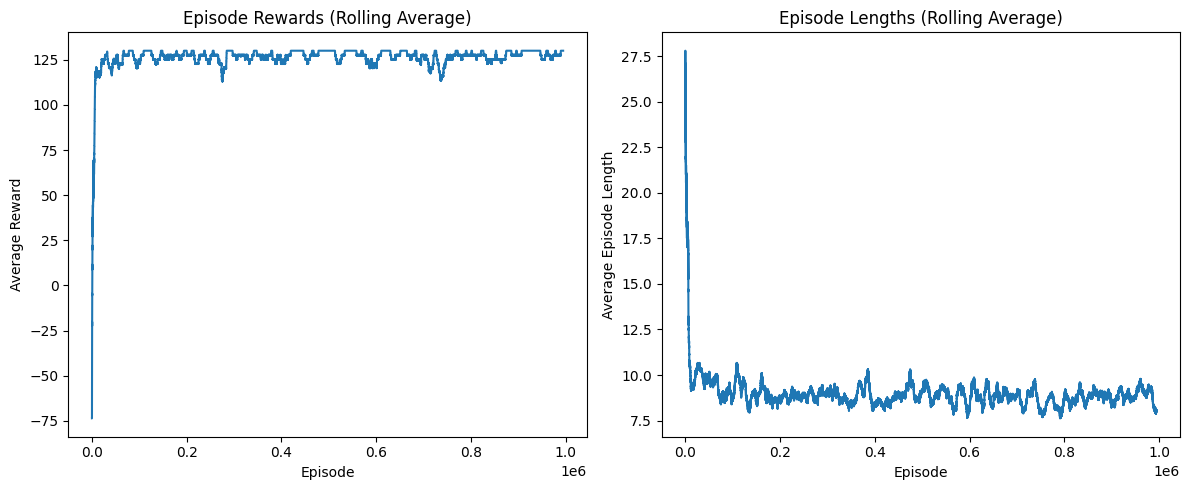

In [10]:
rolling_length = 500
if len(episode_rewards) >= rolling_length:
    # Calcolo della media mobile per i reward
    reward_moving_average = (
        np.convolve(episode_rewards, np.ones(rolling_length), mode="valid") / rolling_length
    )
    # Calcolo della media mobile per le lunghezze degli episodi
    length_moving_average = (
        np.convolve(episode_lengths, np.ones(rolling_length), mode="valid") / rolling_length
    )

    # Creazione dei subplot
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # Grafico delle medie mobili dei reward
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[0].set_title("Episode Rewards (Rolling Average)")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Average Reward")

    # Grafico delle medie mobili delle lunghezze degli episodi
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    axs[1].set_title("Episode Lengths (Rolling Average)")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Average Episode Length")

    plt.tight_layout()
    plt.show()
else:
    print("Not enough episodes to calculate the rolling averages for the specified length.")